In [1]:
import uncprop as up
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
from jax import config

from uncprop.core.inverse_problem import Posterior
from uncprop.core.surrogate import construct_design
from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars
from uncprop.utils.plot import set_plot_theme
from uncprop.utils.grid import Grid
from uncprop.models.vsem.inverse_problem import VSEMPrior, VSEMLikelihood
from uncprop.models.vsem.surrogate import VSEMSurrogate
from uncprop.models.vsem.vsem_jax import simulate_vsem_driver

config.update("jax_enable_x64", True)
key = jr.key(53212)

colors = set_plot_theme()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Construct VSEM Inverse Problem

In [6]:
from uncprop.models.vsem.vsem_jax import (
    build_vectorized_partial_forward_model,
)

from uncprop.models.vsem.inverse_problem import (
    define_vsem_observation_operator,
    DataGeneratingProcess,
    CalibrationModel,
    DataRealization,
    VSEM_DEFAULT_PARAMS,
)

n_months = 24
n_days_per_month = 30
n_days = n_months * n_days_per_month
par_names = ['kext', 'av']
observed_variable = 'lai'
noise_sd = 0.1
noise_cov = (noise_sd ** 2) * jnp.identity(n_months)
noise_cov_tril = jnp.sqrt(noise_cov)

key, key_prior, key_driver = jr.split(key, 3)

prior = VSEMPrior(par_names)
all_true_param = prior.sample_all_vsem_params(key_prior)
time_steps, driver = simulate_vsem_driver(key_driver, n_days)

obs_op_info = define_vsem_observation_operator(num_days=n_days, 
                                               window_len=n_days_per_month,
                                               vsem_output_var=observed_variable)

In [7]:
import jax

key, key_driver, key_obs = jr.split(key, 3)

true_dgp = DataGeneratingProcess(
    driver_key=key_driver,
    driver=driver,
    vsem_params=VSEM_DEFAULT_PARAMS,
    observation_operator_info=obs_op_info,
    noise_cov_tril=noise_cov_tril
)

calibration_model = CalibrationModel(
    driver=true_dgp.driver,
    vsem_params=true_dgp.vsem_params,
    calibration_params=par_names,
    observation_operator_info=true_dgp.observation_operator_info,
    noise_cov_tril=true_dgp.noise_cov_tril
)

observation_info = DataRealization(
    obs_key=key_obs,
    data_generating_process=true_dgp
)

# jitted parameter-to-observation map
param_to_obs_map = lambda x: calibration_model.param_to_observable_map(x)
param_to_obs_map = jax.jit(param_to_obs_map)


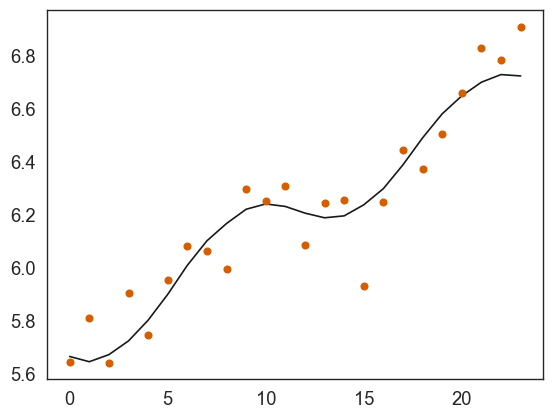

In [8]:
import matplotlib.pyplot as plt

key, key_temp = jr.split(key, 2)
param = prior.sample(key_temp)
output = param_to_obs_map(param).ravel()

plt.plot(observation_info.observable, 'k')
plt.plot(observation_info.observation, 'ro')
plt.show()

In [ ]:
n_days = 365 * 2
par_names = ["kext", "av"]

key, key_prior, key_driver, key_likelihood, key_mcmc = jr.split(key, 5)

# exact posterior
prior = VSEMPrior(par_names)
true_param = prior.sample_all_vsem_params(key_prior)
time_steps, driver = simulate_vsem_driver(key_driver, n_days)
likelihood = VSEMLikelihood(key=key_likelihood,
                            par_names=par_names,
                            time_steps=time_steps,
                            driver=driver,
                            ground_truth=true_param)
posterior = Posterior(prior=prior, likelihood=likelihood)

# visualize posterior over grid
grid = Grid(low=prior.support[0],
            high=prior.support[1],
            n_points_per_dim=(50, 50),
            dim_names=prior.par_names)

grid.plot(f=lambda x: posterior.log_density(x),
          title='unnormalized log posterior')

In [ ]:
l = posterior.likelihood

In [ ]:
import jax
ljit = jax.jit(l)

In [ ]:
x = posterior.prior.sample(key, n=5)
ljit(x)

In [ ]:
samp = posterior.sample(key_mcmc, n=4000)

### Fit Surrogate

In [ ]:
key, key_design = jr.split(key, 2)

# sample design points
design = construct_design(key=key_design,
                          design_method='lhc', 
                          n_design=15, 
                          prior=prior,
                          f=lambda x: posterior.log_density(x))

# fit log-posterior surrogate
surrogate = VSEMSurrogate(design=design, exact_posterior=posterior)
surrogate.summarize_fit()

In [ ]:
arr = jnp.array([1,2,3])
nm = ['a', 'b', 'c']

dict(zip(nm, arr))

In [ ]:
from datetime import date
import jax
import jax.scipy.stats as stats
import numpy as np

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)
logdensity = lambda x: logdensity_fn(**x)

In [ ]:
from uncprop.core.samplers import init_nuts_kernel, mcmc_loop

initial_position = {"loc": 1.0, "log_scale": 1.0}
init_state, kernel = init_nuts_kernel(rng_key, logdensity, initial_position, num_warmup_steps=100)

In [ ]:
key, mcmc_key = jr.split(rng_key)

states = mcmc_loop(mcmc_key, kernel, init_state, num_samples=4000)

In [ ]:
from uncprop.core.samplers import get_trace_plots

fig, ax = get_trace_plots(states.position)
display(fig)